In [ ]:
import os
import warnings

warnings.filterwarnings("ignore")

os.chdir("../../..")

In [ ]:
!python --version

Python 3.7.11


In [ ]:
pip install pytorch-lightning==1.1.8

  Using cached https://files.pythonhosted.org/packages/e7/d4/d2751586c7961f238a6077a6dc6e4a9214445da3219f463aa44b29fe4b42/pytorch_lightning-1.1.8-py3-none-any.whl
ERROR: pytorch-forecasting 0.8.4 has requirement fsspec<0.9.0,>=0.8.5, but you'll have fsspec 2021.7.0 which is incompatible.
  Found existing installation: pytorch-lightning 1.2.5
    Uninstalling pytorch-lightning-1.2.5:
      Successfully uninstalled pytorch-lightning-1.2.5


In [ ]:
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning

  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-ekpbki3t
  Running command git clone -q https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-ekpbki3t
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 829kB 6.8MB/s 
     |████████████████████████████████| 10.6MB 25.6MB/s 
     |████████████████████████████████| 645kB 40.8MB/s 
     |████████████████████████████████| 122kB 40.8MB/s 
     |████████████████████████████████| 235kB 43.3MB/s 
     |████████████████████████████████| 1.3MB 43.5MB/s 
     |████████████████████████████████| 296kB 42.9MB/s 
     |████████████████████████████████| 143kB 54.1MB/s 
  Created wheel for pytorch-lightning: filename=pytorch_lightning-1.4.0.dev0-cp37-none-any.whl size=900426 sha256=ae95e316ed4c1b07500a4e13c7f9cfb4221e8c94ef0

In [ ]:
pip install pytorch-forecasting==0.8.4

     |████████████████████████████████| 112kB 8.5MB/s 
     |████████████████████████████████| 819kB 14.4MB/s 
     |████████████████████████████████| 307kB 29.5MB/s 
     |████████████████████████████████| 22.3MB 1.9MB/s 
     |████████████████████████████████| 112kB 59.0MB/s 
     |████████████████████████████████| 10.6MB 38.8MB/s 
     |████████████████████████████████| 645kB 42.5MB/s 
     |████████████████████████████████| 235kB 53.4MB/s 
     |████████████████████████████████| 829kB 38.7MB/s 
     |████████████████████████████████| 81kB 12.7MB/s 
     |████████████████████████████████| 174kB 53.4MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 143kB 53.8MB/s 
     |████████████████████████████████| 112kB 59.0MB/s 
     |████████████████████████████████| 81kB 12.5MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=8931d4cf14dd1456b5c377b04248e4eef6968bdfbd8a70676b7aa634bf95dea8
  Stored in

In [ ]:
pip install torch -f https://download.pytorch.org/whl/torch_stable.html.

Looking in links: https://download.pytorch.org/whl/torch_stable.html.


In [ ]:
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE

/usr/local/lib/python3.7/dist-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `Metric` was deprecated since v1.3.0 in favor of `torchmetrics.metric.Metric`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


In [ ]:
# data = generate_ar_data(seasonality=10.0, timesteps=400, n_series=100, seed=42)
# data["static"] = 2
# data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")
# data.head()

data = pd.read_csv('/content/sunday_csv.csv', usecols=['series', 'time_idx', 'node_values'])
print(data)

      time_idx  series  node_values
0            1       0       -0.999
1            2       0       -1.998
2            3       0       -2.997
3            4       0       -3.996
4            5       0       -4.995
...        ...     ...          ...
5204      5205       0    -3012.889
5205      5206       0    -3013.888
5206      5207       0    -3012.888
5207      5208       0    -3013.887
5208      5209       0    -3012.887

[5209 rows x 3 columns]


In [ ]:
print(training_cutoff)

4012


In [ ]:
# from google.colab import files
# data.to_csv('n-beats.csv') 
# files.download('n-beats.csv')

In [ ]:

# create dataset and dataloaders
max_encoder_length = 2000
max_prediction_length = 1000

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="node_values",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["node_values"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)



In [ ]:
dir(val_dataloader)

['_DataLoader__initialized',
 '_DataLoader__multiprocessing_context',
 '_IterableDataset_len_called',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_collation',
 '_dataset_kind',
 '_get_iterator',
 '_index_sampler',
 '_iterator',
 'batch_sampler',
 'batch_size',
 'check_worker_number_rationality',
 'collate_fn',
 'dataset',
 'drop_last',
 'generator',
 'multiprocessing_context',
 'num_workers',
 'persistent_workers',
 'pin_memory',
 'prefetch_factor',
 'sampler',
 'timeout',
 'worker_init_fn']

In [ ]:
# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(0.1015)

In [ ]:
print(baseline_predictions)

tensor([[-2449.6689, -2449.6689, -2449.6689, -2449.6689, -2449.6689, -2449.6689,
         -2449.6689, -2449.6689, -2449.6689, -2449.6689, -2449.6689, -2449.6689,
         -2449.6689, -2449.6689, -2449.6689, -2449.6689, -2449.6689, -2449.6689,
         -2449.6689, -2449.6689, -2449.6689, -2449.6689, -2449.6689, -2449.6689,
         -2449.6689, -2449.6689, -2449.6689, -2449.6689, -2449.6689, -2449.6689,
         -2449.6689, -2449.6689, -2449.6689, -2449.6689, -2449.6689, -2449.6689,
         -2449.6689, -2449.6689, -2449.6689, -2449.6689, -2449.6689, -2449.6689,
         -2449.6689, -2449.6689, -2449.6689, -2449.6689, -2449.6689, -2449.6689,
         -2449.6689, -2449.6689, -2449.6689, -2449.6689, -2449.6689, -2449.6689,
         -2449.6689, -2449.6689, -2449.6689, -2449.6689, -2449.6689, -2449.6689,
         -2449.6689, -2449.6689, -2449.6689, -2449.6689, -2449.6689, -2449.6689,
         -2449.6689, -2449.6689, -2449.6689, -2449.6689, -2449.6689, -2449.6689,
         -2449.6689, -2449.6

In [ ]:
pl.seed_everything(42)
trainer = pl.Trainer(gpus=1, gradient_clip_val=0.1)
net = NBeats.from_dataset(training, learning_rate=3e-2,num_blocks=[3, 3],num_block_layers=[3, 3],  weight_decay=1e-2, widths=[256, 2048], backcast_loss_ratio=0.1, sharing = True)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 45.6 M
-----------------------------------------------
45.6 M    Trainable params
0         Non-trainable params
45.6 M    Total params
182.200   Total estimated model params size (MB)
Global seed set to 42


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{}
--------------------------------------------------------------------------------
-------------------------

LR finder stopped early after 75 steps due to diverging loss.


Restored states from the checkpoint file at /lr_find_temp_model.ckpt


suggested learning rate: 7.07945784384138e-05


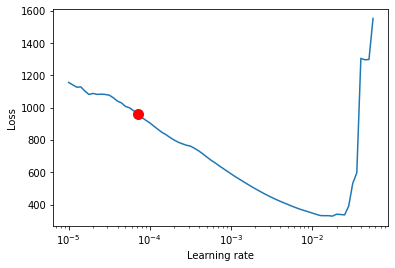

In [ ]:
# find optimal learning rate
res = trainer.tuner.lr_find(net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=2, mode="min")
trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=128,
)


net = NBeats.from_dataset(
    training,
    learning_rate=5e-3,
    num_blocks=[3, 3],
    num_block_layers=[3, 3],
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    widths=[256, 2048],
    backcast_loss_ratio=1.0,
    loss= SMAPE()

)

trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | SMAPE      | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 45.6 M
-----------------------------------------------
45.6 M    Trainable params
0         Non-trainable params
45.6 M    Total params
182.200   Total estimated model params size (MB)


Global seed set to 42


Metric val_loss improved. New best score: 0.077


Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.074


Metric val_loss improved by 0.032 >= min_delta = 0.0001. New best score: 0.042


Metric val_loss improved by 0.027 >= min_delta = 0.0001. New best score: 0.015


Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.013


Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.009


Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.009


Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.008


Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.007


Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.006


Monitored metric val_loss did not improve in the last 10 records. Best score: 0.006. Signaling Trainer to stop.


In [ ]:
print(net)

NBeats(
  (loss): SMAPE()
  (logging_metrics): ModuleList(
    (0): SMAPE()
    (1): MAE()
    (2): RMSE()
    (3): MAPE()
    (4): MASE()
  )
  (net_blocks): ModuleList(
    (0): NBEATSTrendBlock(
      (fc): Sequential(
        (0): Linear(in_features=2000, out_features=256, bias=True)
        (1): ReLU()
        (2): Sequential(
          (0): Dropout(p=0.1, inplace=False)
          (1): Linear(in_features=256, out_features=256, bias=True)
        )
        (3): ReLU()
        (4): Sequential(
          (0): Dropout(p=0.1, inplace=False)
          (1): Linear(in_features=256, out_features=256, bias=True)
        )
        (5): ReLU()
      )
      (theta_f_fc): Linear(in_features=256, out_features=3, bias=False)
      (theta_b_fc): Linear(in_features=256, out_features=3, bias=False)
    )
    (1): NBEATSTrendBlock(
      (fc): Sequential(
        (0): Linear(in_features=2000, out_features=256, bias=True)
        (1): ReLU()
        (2): Sequential(
          (0): Dropout(p=0.1, inpl

In [ ]:
from torchsummary import summary
summary(net)

TypeError: ignored

In [ ]:
net.hparams

"backcast_loss_ratio":           1.0
"context_length":                2000
"dropout":                       0.1
"expansion_coefficient_lengths": [3, 7]
"learning_rate":                 0.005
"log_gradient_flow":             False
"log_interval":                  10
"log_val_interval":              1
"logging_metrics":               ModuleList(
  (0): SMAPE()
  (1): MAE()
  (2): RMSE()
  (3): MAPE()
  (4): MASE()
)
"loss":                          SMAPE()
"monotone_constaints":           {}
"num_block_layers":              [3, 3]
"num_blocks":                    [3, 3]
"optimizer":                     ranger
"optimizer_params":              None
"output_transformer":            EncoderNormalizer()
"prediction_length":             1000
"reduce_on_plateau_min_lr":      1e-05
"reduce_on_plateau_patience":    1000
"sharing":                       [True, True]
"stack_types":                   ['trend', 'seasonality']
"weight_decay":                  0.01
"widths":                        [256

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
# (actuals - predictions).abs().mean()
SMAPE()(predictions, actuals)

tensor(0.0073)

In [ ]:
print(actuals)


tensor([[-2450.6680, -2449.6680, -2450.6670, -2449.6670, -2450.6660, -2451.6650,
         -2452.6641, -2453.6631, -2454.6621, -2453.6621, -2454.6609, -2453.6609,
         -2452.6609, -2451.6609, -2452.6599, -2453.6589, -2452.6589, -2453.6580,
         -2452.6580, -2453.6570, -2452.6570, -2453.6560, -2454.6550, -2455.6541,
         -2456.6531, -2457.6521, -2458.6509, -2459.6499, -2460.6489, -2459.6489,
         -2460.6479, -2461.6470, -2462.6460, -2463.6450, -2464.6440, -2465.6431,
         -2466.6421, -2465.6421, -2466.6411, -2467.6399, -2468.6389, -2467.6389,
         -2468.6379, -2469.6370, -2470.6360, -2471.6350, -2470.6350, -2471.6340,
         -2472.6331, -2473.6321, -2472.6321, -2473.6311, -2474.6299, -2475.6289,
         -2476.6279, -2477.6270, -2478.6260, -2479.6250, -2480.6240, -2481.6230,
         -2480.6230, -2481.6221, -2480.6221, -2481.6211, -2482.6201, -2483.6189,
         -2484.6179, -2483.6179, -2484.6169, -2485.6160, -2484.6160, -2485.6150,
         -2484.6150, -2483.6

In [ ]:
x_np = actuals.numpy()
x_df = pd.DataFrame(x_np)
x_df.to_csv('/content/act_csv.csv')

In [ ]:
print(predictions)
y_np = predictions.numpy()
y_df = pd.DataFrame(y_np)
y_df.to_csv('/content/pred_csv.csv')

tensor([[-2436.0522, -2433.1880, -2431.0259, -2432.1018, -2436.9382, -2443.7300,
         -2449.5288, -2452.1191, -2451.3313, -2448.9795, -2447.5220, -2448.3884,
         -2451.0791, -2453.5952, -2453.8779, -2451.2617, -2447.0142, -2443.6167,
         -2443.2817, -2446.6199, -2452.2866, -2457.7361, -2460.6313, -2460.0190,
         -2456.6904, -2452.5728, -2449.6262, -2448.8799, -2450.1160, -2452.2725,
         -2454.2319, -2455.5010, -2456.4126, -2457.7805, -2460.2585, -2463.8010,
         -2467.5552, -2470.2554, -2470.9126, -2469.4204, -2466.6973, -2464.2668,
         -2463.4495, -2464.6309, -2467.0181, -2469.0784, -2469.4272, -2467.6594,
         -2464.6272, -2461.9622, -2461.1306, -2462.5828, -2465.5291, -2468.4775,
         -2470.1819, -2470.3823, -2469.8604, -2469.7969, -2470.8860, -2472.8223,
         -2474.5195, -2474.9148, -2473.7866, -2472.0127, -2471.0513, -2471.9976,
         -2474.8296, -2478.3640, -2480.9453, -2481.4250, -2479.7791, -2477.0073,
         -2474.4321, -2472.9

In [ ]:
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

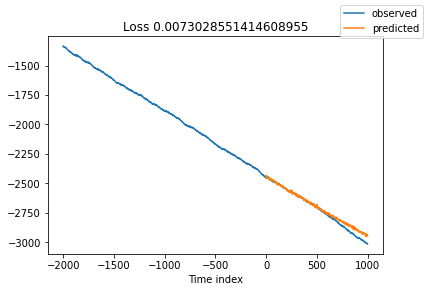

In [ ]:
for idx in range(1):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

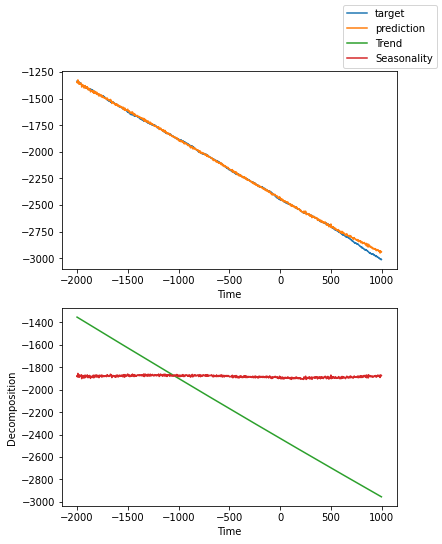

In [ ]:
for idx in range(1):  # plot 10 examples
    best_model.plot_interpretation(x, raw_predictions, idx=idx );